# Pastas Noise model

*Developed by Stijn Klop and Mark Bakker*

This Notebook contains a number of examples and tests with synthetic data. The purpose of this notebook is to demonstrate the noise model of Pastas.

In this Notebook, heads are generated with a known response function. Next, Pastas is used to solve for the parameters of the model it is verified that Pastas finds the correct parameters back. Several different types of errors are introduced in the generated heads and it is tested whether the confidence intervals computed by Pastas are reasonable. 

The first step is to import all the required python packages.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammainc, gammaincinv
import pandas as pd
import pastas as ps

## Load data and define functions
The rainfall and reference evaporation are read from file and truncated for the period 1980 - 2000. The rainfall and evaporation series are taken from KNMI station De Bilt. The reading of the data is done using Pastas.

Heads are generated with a Gamma response function which is defined below. 

In [2]:
rain = ps.read.read_knmi('data_notebook_5/etmgeg_260.txt', variables='RH').series
evap = ps.read.read_knmi('data_notebook_5/etmgeg_260.txt', variables='EV24').series
rain = rain['1980':'1999']
evap = evap['1980':'1999']

In [3]:
def gamma_tmax(A, n, a, cutoff=0.99):
    return gammaincinv(n, cutoff) * a

def gamma_step(A, n, a, cutoff=0.99):
    tmax = gamma_tmax(A, n, a, cutoff)
    t = np.arange(0, tmax, 1)
    s = A * gammainc(n, t / a)
    return s

def gamma_block(A, n, a, cutoff=0.99):
    # returns the gamma block response starting at t=0 with intervals of delt = 1
    s = gamma_step(A, n, a, cutoff)
    return np.append(s[0], s[1:] - s[:-1])

The Gamma response function requires 3 input arguments; A, n and a. The values for these parameters are defined along with the parameter d, the base groundwater level. The response function is created using the functions defined above.

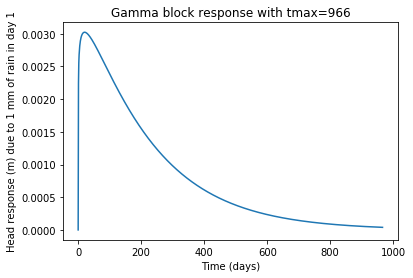

In [4]:
Atrue = 800
ntrue = 1.1
atrue = 200
dtrue = 20
h = gamma_block(Atrue, ntrue, atrue) * 0.001
tmax = gamma_tmax(Atrue, ntrue, atrue)
plt.plot(h)
plt.xlabel('Time (days)')
plt.ylabel('Head response (m) due to 1 mm of rain in day 1')
plt.title('Gamma block response with tmax=' + str(int(tmax)));

### Create synthetic observations
Rainfall is used as input series for this example. No errors are introduced. A Pastas model is created to test whether Pastas is able to . The generated head series is purposely not generated with convolution.
Heads are computed for the period 1990 - 2000. Computations start in 1980 as a warm-up period. Convolution is not used so that it is clear how the head is computed. The computed head at day 1 is the head at the end of day 1 due to rainfall during day 1. No errors are introduced.

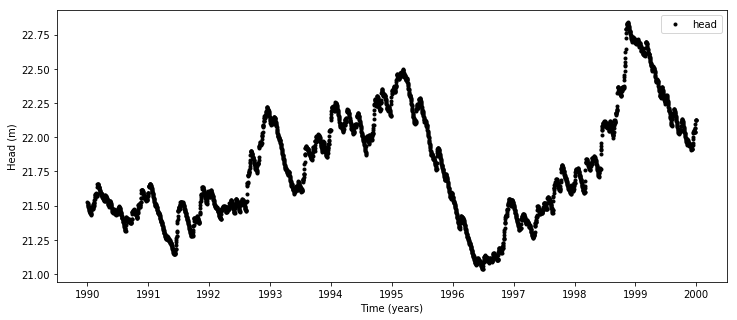

In [5]:
step = gamma_block(Atrue, ntrue, atrue)[1:]
lenstep = len(step)
h = dtrue * np.ones(len(rain) + lenstep)
for i in range(len(rain)):
    h[i:i + lenstep] += rain[i] * step
head = pd.DataFrame(index=rain.index, data=h[:len(rain)],)
head = head['1990':'1999']

plt.figure(figsize=(12,5))
plt.plot(head,'k.', label='head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Time (years)');

### Create Pastas model
The next step is to create a Pastas model. The head generated using the Gamma response function is used as input for the Pastas model. 

A `StressModel` instance is created and added to the Pastas model. The `StressModel` intance takes the rainfall series as input aswell as the type of response function, in this case the Gamma response function ( `ps.Gamma`).

The Pastas model is solved without a noise model since there is no noise present in the data. The results of the Pastas model are plotted.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 
Model Results 0               Fit Statistics
nfev     11                     EVP   100.00
nobs     3652                   R2      1.00
noise    0                      RMSE    0.00
tmin     1990-01-01 00:00:00    AIC      nan
tmax     1999-12-31 00:00:00    BIC      nan
freq     D                      ___         
warmup   3650                   ___         
solver   LeastSquares           ___         

Parameters (4 were optimized)
            optimal  stderr     initial vary
recharge_A    800.0  ±0.00%  224.669629    1
recharge_n      1.1  ±0.00%    1.000000    1
recharge_a    200.0  ±0.00%   10.000000    1
constant_d     20.0  ±0.00%   21.783161    1


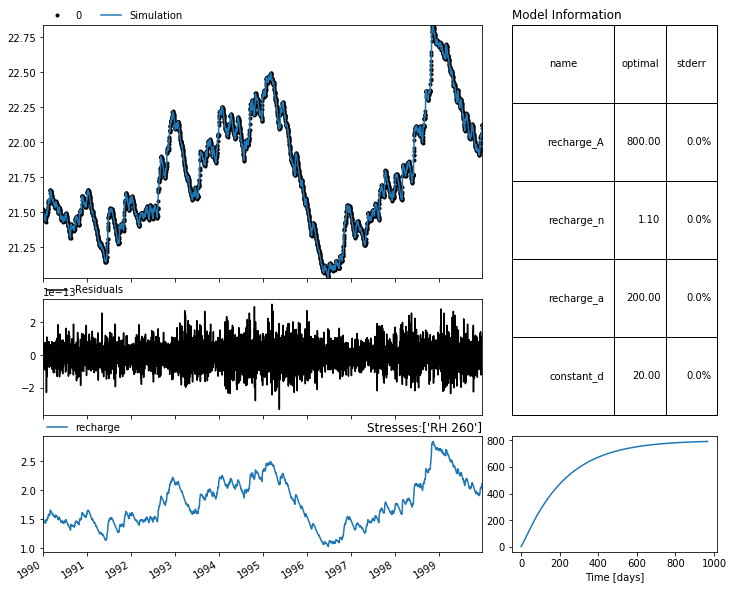

In [6]:
ml = ps.Model(head)
sm = ps.StressModel(rain, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm)
ml.solve(noise=False)
ml.plots.results();

The results of the Pastas model show the calibrated parameters for the Gamma response function. The parameters calibrated using pastas are equal to the `Atrue`, `ntrue`, `atrue` and `dtrue` parameters defined above. The Explained Variance Percentage for this example model is 100%. 

The results plots show that the Pastas simulation is identical to the observed groundwater. The residuals of the simulation are shown in the plot together with the response function and the contribution for each stress.

Below the Pastas block response and the true Gamma response function are plotted.

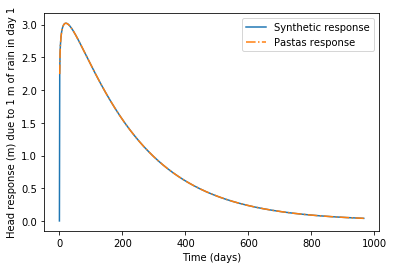

In [7]:
plt.plot(gamma_block(Atrue, ntrue, atrue), label='Synthetic response')
plt.plot(ml.get_block_response('recharge'), '-.', label='Pastas response')
plt.legend(loc=0)
plt.ylabel('Head response (m) due to 1 m of rain in day 1')
plt.xlabel('Time (days)');

### Test 1: Adding noise
In the next test example noise is added to the observations of the groundwater head. The noise is normally distributed noise with a mean of 0 and a standard deviation of 1 and is scaled with the standard deviation of the head. 

The noise series is added to the head series created in the previous example.

In [8]:
random_seed = np.random.RandomState(15892)

noise = random_seed.normal(0,1,len(head)) * np.std(head.values) * 0.5
head_noise = head[0] + noise

### Create Pastas model

A pastas model is created using the head with noise. A stress model is added to the Pastas model and the model is solved.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 
Model Results 0                    Fit Statistics
nfev     15                     EVP         79.43
nobs     3652                   R2           0.79
noise    1                      RMSE         0.20
tmin     1990-01-01 00:00:00    AIC         -0.04
tmax     1999-12-31 00:00:00    BIC         30.98
freq     D                      ___              
warmup   3650                   ___              
solver   LeastSquares           ___              

Parameters (5 were optimized)
                optimal   stderr     initial vary
recharge_A   811.496177   ±1.23%  224.669629    1
recharge_n     1.047278   ±1.67%    1.000000    1
recharge_a   218.437790   ±3.33%   10.000000    1
constant_d    19.981020   ±0.10%   21.788543    1
noise_alpha    0.186436  ±65.92%   14.000000    1


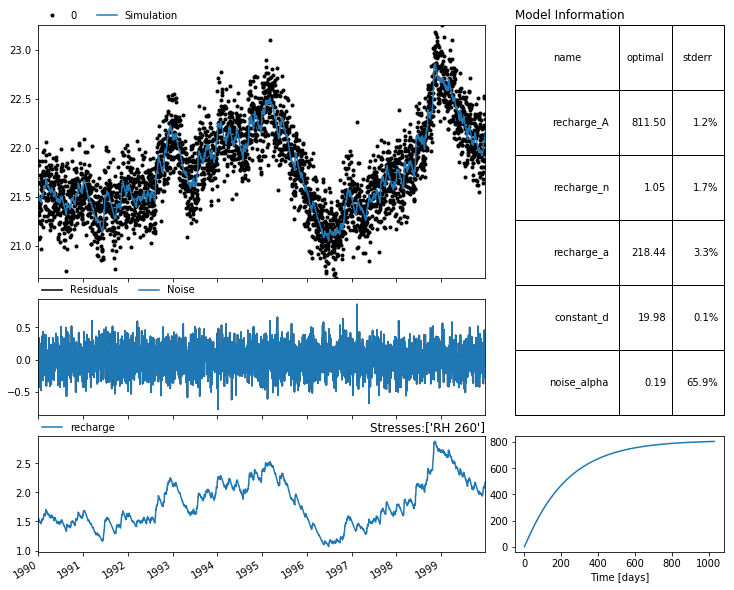

In [9]:
ml2 = ps.Model(head_noise)
sm2 = ps.StressModel(rain, ps.Gamma, name='recharge', settings='prec')
ml2.add_stressmodel(sm2)
ml2.solve(noise=True)
ml2.plots.results();

The results of the simulation show that Pastas is able to filter the noise from the observed groundwater head. The simulated groundwater head and the generated synthetic head are plotted below. The parameters found with the Pastas optimization are similair to the original parameters of the Gamma response function.

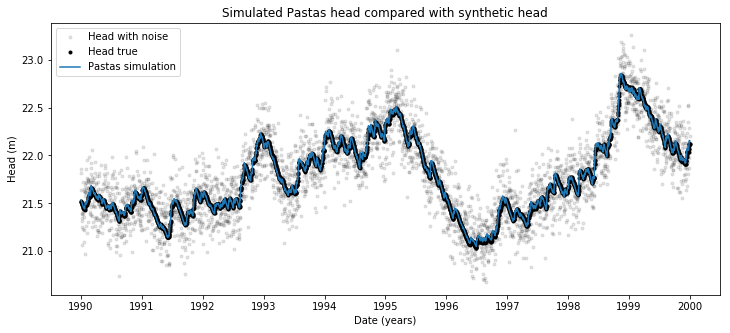

In [10]:
plt.figure(figsize=(12,5))
plt.plot(head_noise, '.k', alpha=0.1, label='Head with noise')
plt.plot(head, '.k', label='Head true')
plt.plot(ml2.simulate(), label='Pastas simulation')
plt.title('Simulated Pastas head compared with synthetic head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Date (years)');

### Test 2: Adding correlated noise
In this example correlated noise is added to the observed head. The correlated noise is generated using the noise series created in the previous example. The correlated noise is implemented as exponential decay using the following formula:

$$ n_{c}(t) = e^{-1/\alpha} \cdot n_{c}(t-1) + n(t)$$

where $n_{c}$ is the correlated noise, $\alpha$ is the noise decay parameter and $n$ is the uncorrelated noise. The noise series that is created is added to the observed groundwater head. 

In [11]:
noise_corr = np.zeros(len(noise))
noise_corr[0] = noise[0]

alphatrue = 2

for i in range(1, len(noise_corr)):
    noise_corr[i] = np.exp(-1/alphatrue) * noise_corr[i - 1] + noise[i]
    
head_noise_corr = head[0] + noise_corr

### Create Pastas model
A Pastas model is created using the head with correlated noise as input. A stressmodel is added to the model and the Pastas model is solved. The results of the model are plotted. 

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 
Model Results 0                   Fit Statistics
nfev     14                     EVP        70.24
nobs     3652                   R2          0.70
noise    1                      RMSE        0.26
tmin     1990-01-01 00:00:00    AIC        -0.04
tmax     1999-12-31 00:00:00    BIC        30.98
freq     D                      ___             
warmup   3650                   ___             
solver   LeastSquares           ___             

Parameters (5 were optimized)
                optimal  stderr     initial vary
recharge_A   820.980266  ±3.25%  224.669629    1
recharge_n     1.016380  ±3.59%    1.000000    1
recharge_a   234.903759  ±7.93%   10.000000    1
constant_d    19.888420  ±0.29%   21.796814    1
noise_alpha    2.075869  ±4.38%   14.000000    1


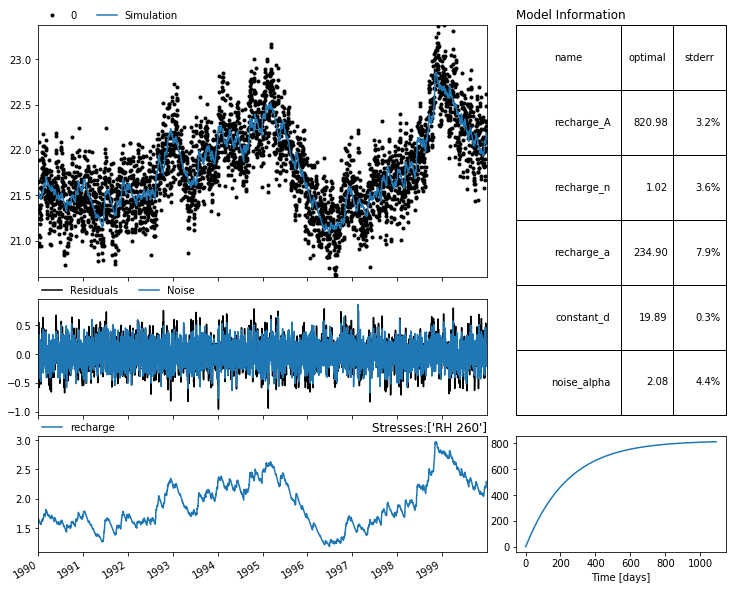

In [23]:
ml3 = ps.Model(head_noise_corr)
ml3.add_noisemodel(ps.NoiseModel2())
sm3 = ps.StressModel(rain+0.0001, ps.Gamma, name='recharge', settings='prec')
ml3.add_stressmodel(sm3)
ml3.solve(noise=True)
ml3.plots.results();

The Pastas model is able to calibrate the model parameters fairly well. The calibrated parameters are close to the true values defined above. The `noise_alpha` parameter calibrated by Pastas is close the the `alphatrue` parameter defined for the correlated noise series.

Below the head simulated with the Pastas model is plotted together with the head series and the head series with the correlated noise.

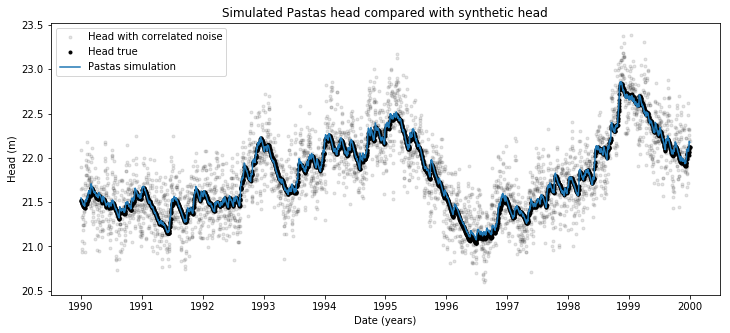

In [13]:
plt.figure(figsize=(12,5))
plt.plot(head_noise_corr, '.k', alpha=0.1, label='Head with correlated noise')
plt.plot(head, '.k', label='Head true')
plt.plot(ml3.simulate(), label='Pastas simulation')
plt.title('Simulated Pastas head compared with synthetic head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Date (years)');